In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import uproot

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors

from src.file_locations import intermediate_files_location


In [2]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

loading all_df.pkl...
all_df.shape=(2171921, 200)


In [3]:
all_df["wc_truth_muonMomentum_3"] = [-1 if isinstance(x, float) else x[3] for x in all_df["wc_truth_muonMomentum"].to_numpy()]

#erin_sig_query = "(wc_match_completeness_energy>0.1*wc_truth_energyInside and wc_truth_single_photon==1 and (wc_truth_isCC==0 or (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==14 and abs(wc_truth_muonMomentum_3-0.105658)<0.1)))"
erin_sig_query = "(wc_truth_single_photon==1 and (wc_truth_isCC==0 or (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==14 and abs(wc_truth_muonMomentum_3-0.105658)<0.1)))"
all_df["erin_inclusive_1g_true_sig"] = all_df.eval(erin_sig_query).astype(int)

erin_sig_df = all_df.query(erin_sig_query)


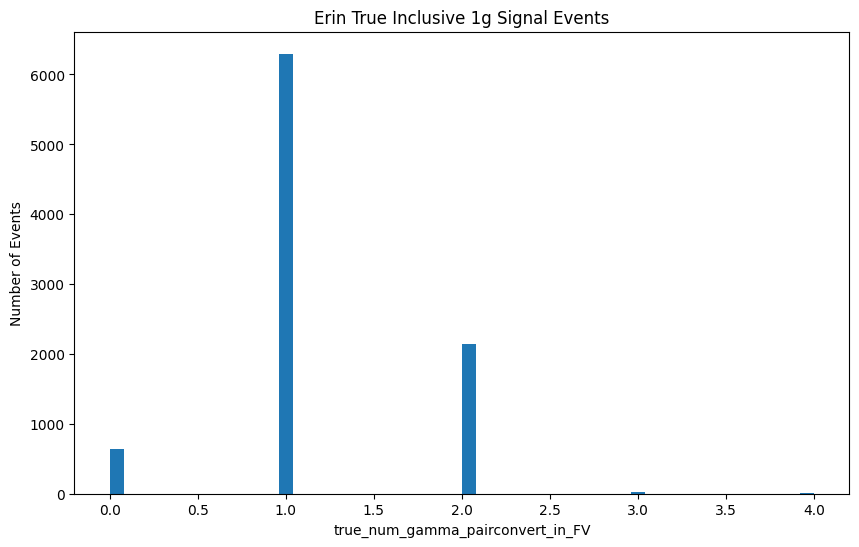

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(erin_sig_df["true_num_gamma_pairconvert_in_FV"], bins=50, weights=erin_sig_df["wc_net_weight"])
plt.xlabel("true_num_gamma_pairconvert_in_FV")
plt.ylabel("Number of Events")
plt.title("Erin True Inclusive 1g Signal Events")
plt.show()


In [21]:
all_df.query("wc_truth_single_photon==1 and true_num_gamma_pairconvert_in_FV == 0")[["filename", "run", "subrun", "event", "true_num_gamma_pairconvert_in_FV", "wc_truth_single_photon", "wc_truth_isCC", "wc_truth_nuPdg", "wc_truth_muonMomentum_3"]].head()


,filename,run,subrun,event,true_num_gamma_pairconvert_in_FV,wc_truth_single_photon,wc_truth_isCC,wc_truth_nuPdg,wc_truth_muonMomentum_3
155,MCC9.10_Run4b_v10_04_07_09_BNB_nu_overlay_surp...,20453,491,24575,0.0,1.0,False,14.0,-1.000000
1292,MCC9.10_Run4b_v10_04_07_09_BNB_nu_overlay_surp...,21137,75,3764,0.0,1.0,True,14.0,2.130009
1340,MCC9.10_Run4b_v10_04_07_09_BNB_nu_overlay_surp...,20021,254,12724,0.0,1.0,True,14.0,0.291022
4754,MCC9.10_Run4b_v10_04_07_09_BNB_nu_overlay_surp...,19997,442,22107,0.0,1.0,False,14.0,-1.000000
4849,MCC9.10_Run4b_v10_04_07_09_BNB_nu_overlay_surp...,20423,175,8760,0.0,1.0,False,14.0,-1.000000


In [6]:
f = uproot.open("/nevis/riverside/data/lhagaman/ngem/data_files/MCC9.10_Run4b_v10_04_07_09_BNB_nu_overlay_surprise_reco2_hist.root")

# loading Wire-Cell variables
dic = {}

dic.update(f["wcpselection"]["T_eval"].arrays(["run", "subrun", "event"], library="np"))
dic.update(f["wcpselection"]["T_PFeval"].arrays(["truth_single_photon", "truth_Ntrack", "truth_id", "truth_pdg", "truth_mother", "truth_startMomentum", "truth_startXYZT", "truth_endXYZT"], library="np"))

for col in dic:
    dic[col] = dic[col].tolist()
df = pd.DataFrame(dic)


In [22]:
interesting_df = df.query("run == 20453 and subrun == 491 and event == 24575")
interesting_df

,run,subrun,event,truth_single_photon,truth_Ntrack,truth_id,truth_pdg,truth_mother,truth_startMomentum,truth_startXYZT,truth_endXYZT
155,20453,491,24575,1,49,"[1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 1...","[14, 2112, 2212, 111, 2112, 2112, 2112, 2112, ...","[0, 0, 0, 0, 0, 5, 5, 5, 5, 4, 4, 2, 2, 2, 2, ...","[[0.20815426, -0.029745, 1.1193933, 1.1389709]...","[[266.11984, -53.168415, 1015.86633, 3508.2388...","[[13903.989, -1997.5035, 74163.0, 5990.6445], ..."


In [23]:
truth_ids = interesting_df["truth_id"].to_numpy()
truth_pdgs = interesting_df["truth_pdg"].to_numpy()
truth_mothers = interesting_df["truth_mother"].to_numpy()
truth_startXYZTs = interesting_df["truth_startXYZT"].to_numpy()
truth_startMomenta = interesting_df["truth_startMomentum"].to_numpy()

truth_energies = []
for i in range(len(truth_startMomenta[0])):
    truth_energies.append(truth_startMomenta[0][i][3])

truth_thetas = []
truth_phis = []
for i in range(len(truth_startMomenta[0])):
    truth_thetas.append(np.rad2deg(np.arccos(truth_startMomenta[0][i][2] / np.linalg.norm(truth_startMomenta[0][i][:3]))))
    truth_phis.append(np.rad2deg(np.arctan2(truth_startMomenta[0][i][1], truth_startMomenta[0][i][0])))

truth_xyz = []
for i in range(len(truth_startXYZTs[0])):
    truth_xyz.append(truth_startXYZTs[0][i][:3])

for i in range(len(truth_ids[0])):
    if truth_pdgs[0][i] < 10_000:
        print(str(truth_ids[0][i]).ljust(6) + " " + str(truth_pdgs[0][i]).ljust(20) + " " + str(truth_mothers[0][i]).ljust(20) + " " + str(truth_energies[i]).ljust(20) + " " + str(truth_xyz[i]).ljust(20) + " " + str(truth_thetas[i]).ljust(20) + " " + str(truth_phis[i]).ljust(20))


1      14                   0                    1.1389709            [ 266.11984   -53.168415 1015.86633 ] 10.638557            -8.132442           
2      2112                 0                    1.0049362            [ 266.11984   -53.168415 1015.86633 ] 43.492878            -166.5175           
3      2212                 0                    0.9826544            [ 266.11984   -53.168415 1015.86633 ] 56.255512            178.9919            
4      111                  0                    0.15944903           [ 266.11984   -53.168415 1015.86633 ] 155.40291            -56.875595          
5      2112                 0                    1.0144302            [ 266.11984   -53.168415 1015.86633 ] 80.06042             -39.480774          
6      2112                 5                    0.9883135            [ 285.8316   -70.49427 1026.106  ] 81.64259             -65.36403           
7      2112                 5                    0.94298977           [ 285.8316   -70.49427 1026.106  

In [24]:
print("id".ljust(10) + "pdg".ljust(20) + "mother".ljust(20) + "energy".ljust(20) + "xyz".ljust(40) + "theta".ljust(20) + "phi".ljust(20))

for i in range(len(truth_ids[0])):
    if truth_pdgs[0][i] < 10_000 and truth_pdgs[0][i] not in [2112, 2212, 211]:
        print(str(truth_ids[0][i]).ljust(10) + str(truth_pdgs[0][i]).ljust(20) + str(truth_mothers[0][i]).ljust(20) + str(truth_energies[i]).ljust(20) + str(truth_xyz[i]).ljust(40) + str(truth_thetas[i]).ljust(20) + str(truth_phis[i]).ljust(20))

"""
tpc_min_x = -1.
tpc_max_x = 254.3
tpc_min_y = -115.
tpc_max_y = 117.
tpc_min_z = 0.6
tpc_max_z = 1036.4
"""

id        pdg                 mother              energy              xyz                                     theta               phi                 
1         14                  0                   1.1389709           [ 266.11984   -53.168415 1015.86633 ]   10.638557           -8.132442           
4         111                 0                   0.15944903          [ 266.11984   -53.168415 1015.86633 ]   155.40291           -56.875595          
12        22                  4                   0.058701243         [ 266.11984   -53.168415 1015.86633 ]   71.452              -26.232445          
13        22                  4                   0.10074777          [ 266.11984   -53.168415 1015.86633 ]   162.06905           -170.74072          
1178      11                  13                  0.08862148          [257.67218 -53.41836 991.2445 ]         163.14265           -164.48804          
1181      11                  12                  0.044462275         [ 272.48816   -57.292347

'\ntpc_min_x = -1.\ntpc_max_x = 254.3\ntpc_min_y = -115.\ntpc_max_y = 117.\ntpc_min_z = 0.6\ntpc_max_z = 1036.4\n'